In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import os

from scale.plot import plot_confusion_matrix, plot_embedding, plot_heatmap
from scale.utils import read_labels, reassign_cluster_with_ref, pairwise_pearson
from scale.specifity import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [3]:
input_dir = '../data/GM12878vsHL/' ## containing data.txt and labels.txt
out_dir = '../result/GM12878vsHL/' ## all running results saved in the out_dir

In [4]:
raw = pd.read_csv(input_dir+'data.txt', sep='\t', index_col=0)
ref, classes, le = read_labels(input_dir+'labels.txt', return_enc=True)
y = le.inverse_transform(ref)

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 1. Feature embedding
different color representing ground truth cell types

In [5]:
os.makedirs('tsne', exist_ok=True)

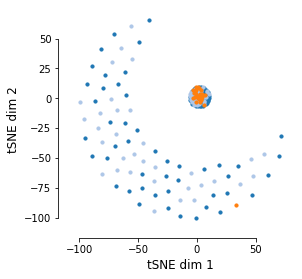

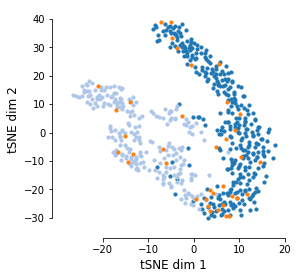

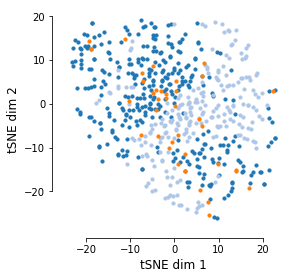

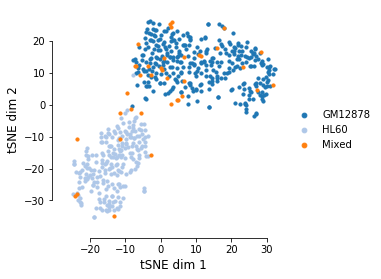

In [6]:
feature = pd.read_csv(out_dir+'feature.txt', sep='\t', index_col=0, header=None)
scVI_feature = pd.read_csv(out_dir+'scVI_latent.txt', sep='\t', index_col=0, header=None)
pca_feature = PCA(n_components=10, random_state=124).fit_transform(raw.T)

plot_embedding(raw.T, y, classes, show_legend=False, save_emb='tsne/raw_emb.txt', save='tsne/raw_emb.pdf')
plot_embedding(pca_feature, y, classes, show_legend=False, save_emb='tsne/pca_emb.txt', save='tsne/pca_emb.pdf')
plot_embedding(scVI_feature, y, classes, show_legend=False, save_emb='tsne/scvi_emb.txt', save='tsne/scvi_emb.pdf')
plot_embedding(feature, y, classes, show_legend=True, save_emb='tsne/scale_emb.txt', save='tsne/scale_emb.pdf')

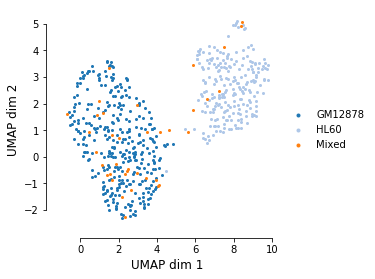

In [5]:
os.makedirs('umap', exist_ok=True)
feature = pd.read_csv(out_dir+'feature.txt', sep='\t', index_col=0, header=None)
plot_embedding(feature, y, classes, show_legend=True, method='UMAP', 
               save_emb='umap/trajectory_emb.txt', save='umap/trajectory_emb.pdf')

## 2. Confusion matrix 
cluster assignments compared with ground truth

In [7]:
os.makedirs('confusion_matrix', exist_ok=True)

In [8]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, f1_score

Method: scABC  ARI score: 0.462  NMI score: 0.406 F1 score: 0.809


/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


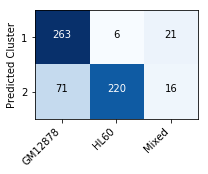

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Method: SC3  ARI score: 0.852  NMI score: 0.793 F1 score: 0.933


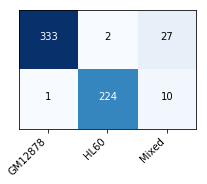

Method: scVI  ARI score: -0.008  NMI score: 0.001 F1 score: 0.497


/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


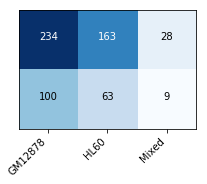

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Method: SCALE  ARI score: 0.866  NMI score: 0.817 F1 score: 0.936


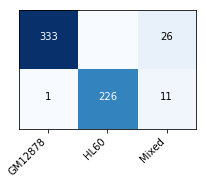

In [9]:
scABC_pred, _ = read_labels(out_dir+'scABC_predict.txt')
SC3_pred, _ = read_labels(out_dir+'SC3_predict.txt')
scVI_pred, _ = read_labels(out_dir+'scVI_predict.txt')
scale_pred, pred_classes = read_labels(out_dir+'cluster_assignments.txt')

show_yticks = True
methods = ['scABC', 'SC3', 'scVI', 'SCALE']
for pred, method in zip([scABC_pred, SC3_pred, scVI_pred, scale_pred], methods):
    pred = reassign_cluster_with_ref(pred, ref)
    ari = adjusted_rand_score(ref, pred)
    nmi = normalized_mutual_info_score(ref, pred)
    f1 = f1_score(ref, pred, average='micro')

    pred = le.inverse_transform(pred)
    cm = confusion_matrix(pred, y, labels=classes)
    
    print("Method: {}  ARI score: {:.3f}  NMI score: {:.3f} F1 score: {:.3f}".format(method, ari, nmi, f1))

    plot_confusion_matrix(cm[:2], classes, pred_classes+1, title='', normalize=False, figsize=(3,3), show_cbar=False, 
                          show_xticks=True, show_yticks=show_yticks, save='confusion_matrix/'+method+'.pdf')   
    show_yticks = False

## 3. Imputation

In [10]:
classes = ['GM12878', 'HL60']

In [11]:
os.makedirs('imputation', exist_ok=True)

In [12]:
imputed = pd.read_csv(out_dir + 'imputed_data.txt', sep='\t', index_col=0)
scimpute = pd.read_csv(out_dir + 'scimpute_count.csv', sep=',', index_col=0)
saver = pd.read_csv(out_dir+'SAVER_imputed.txt', sep='\t', index_col=0)
magic = pd.read_csv(out_dir+'Magic_imputed.txt', sep='\t', index_col=0)
scVI = pd.read_csv(out_dir+'scVI_imputed.txt', sep='\t', index_col=0)

(10431, 597)


#### Cells correlation of imputed data with meta-cells of each cell type

In [13]:
cell_corr = []
cell_method = []
cell_frac = []
methods = ['Raw', 'scImpute', 'SAVER', 'MAGIC', 'scVI', 'SCALE']

row_cluster = True
for i, data in enumerate([raw, scimpute, saver, magic, scVI, imputed]): 
    for c in classes:
        cells = np.where(y==c)[0]
        cell_corr.append(pairwise_pearson(data.iloc[:, cells].T, raw.iloc[:, cells].sum(1)))
        cell_method.append([methods[i]]*len(cells))
        cell_frac.append([c]*len(cells))
cell_corr = pd.Series(np.concatenate(cell_corr, axis=0))
cell_method = pd.Series(np.concatenate(cell_method, axis=0))
cell_frac = pd.Series(np.concatenate(cell_frac, axis=0))

cell_concat = pd.concat([cell_corr, cell_method, cell_frac],  axis=1)
cell_concat.columns = ['correlation with metacell', 'method', 'celltype']
cell_concat.to_csv('imputation/metacell_correlation.txt', sep='\t')

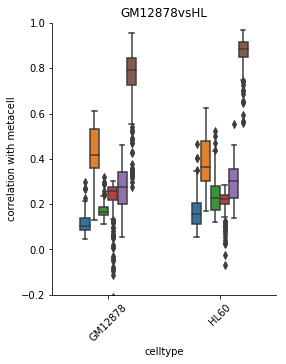

In [14]:
figsize = (min(len(classes)*2, 20), 5)
plt.figure(figsize=figsize)
g = sns.boxplot(x='celltype', y='correlation with metacell', hue='method', width=0.5, data=cell_concat)
plt.ylim(-0.2, 1)
# sns.despine(offset=10, trim=True)
plt.legend().set_visible(False)
plt.title('GM12878vsHL')
# plt.legend(loc='lower left', bbox_to_anchor=(0.8, -0.04))
# # plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.setp(g.get_xticklabels(), rotation=45)
plt.savefig('imputation/metacell_correlation.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### Inter and intra-correlation of subgroups of the raw and the imputed data

scImpute


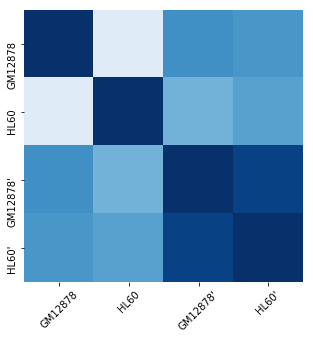

SAVER


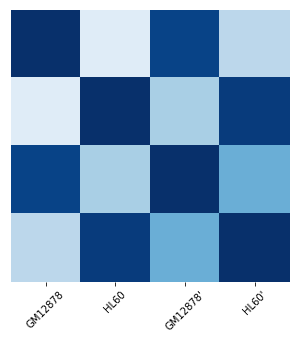

MAGIC


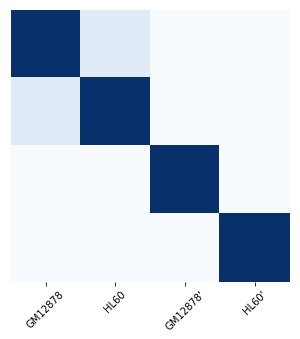

scVI


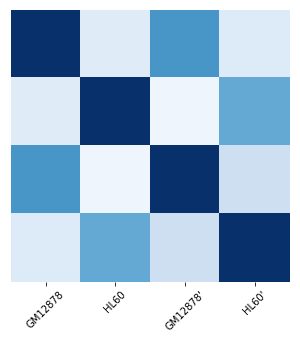

SCALE


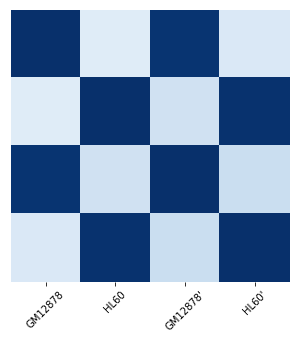

In [17]:
methods = ['scImpute', 'SAVER', 'MAGIC', 'scVI', 'SCALE']
raw_meta = []
scale_meta = []

for c in classes:
    index = np.where(y==c)[0]
    raw_meta.append(raw.iloc[:, index].mean(axis=1))
raw_meta = pd.DataFrame(raw_meta)

yticklabels = True
for i, data in enumerate([scimpute, saver, magic, scVI, imputed]):
    print(methods[i])
    meta = []
    for c in classes:
        index = np.where(y==c)[0]
        meta.append(data.iloc[:, index].mean(axis=1))
    meta = pd.DataFrame(meta)

    plt.figure(figsize=(5,5))
    classes_ = [ c+"'" for c in classes]
    ticklabels = np.concatenate([classes, classes_])
    
    if yticklabels:
        yticklabels = ticklabels
    g = sns.heatmap(np.corrcoef(raw_meta, meta), cmap='Blues', 
                xticklabels=ticklabels, yticklabels=yticklabels, vmin=0.3, vmax=1, cbar=False)
    g.set_xticklabels(ticklabels, rotation=45)
    plt.savefig('imputation/'+methods[i]+'_corr.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    yticklabels=False

## Feature associated peaks

In [20]:
from scale.utils import peak_selection, get_decoder_weight, sort_by_mad
# in the latest release no use of sort_by_mad

In [21]:
os.makedirs('intepret_feature', exist_ok=True)

### feature heatmap

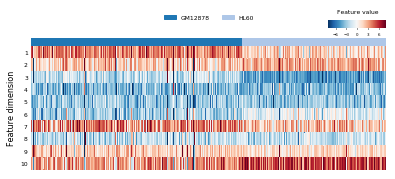

In [18]:
plot_heatmap(feature.T, y, classes=classes, 
             figsize=(8, 3), cmap='RdBu_r', vmax=8, vmin=-8,
             ylabel='Feature dimension', yticklabels=np.arange(10)+1, 
             cax_title='Feature value',
             row_cluster=False, legend_font=6, 
             center=0)

## 4. Cell type specific peaks

In [19]:
from scale.specifity import cluster_specific, mat_specificity_score

In [20]:
scale_pred_ = reassign_cluster_with_ref(scale_pred, ref)
y_pred = np.array(['cluster'+str(i+1) for i in scale_pred_])

In [21]:
score_mat = mat_specificity_score(imputed, ref)

In [22]:
peak_index, peak_labels = cluster_specific(score_mat, le.transform(classes), top=200);print(len(peak_index))
row_labels = ['cluster'+str(c+1) for c in peak_labels]

400


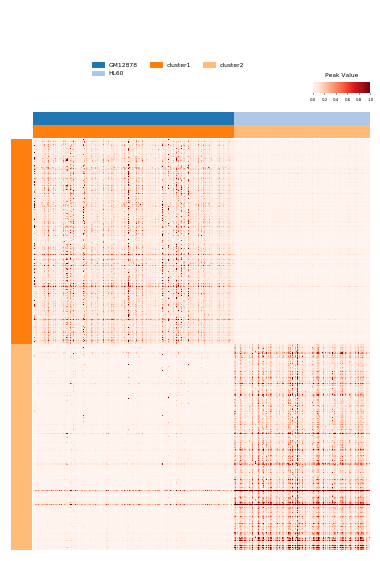

In [23]:
plot_heatmap(imputed.iloc[peak_index], y=y, classes=classes, y_pred=y_pred, row_labels=row_labels, 
             ncol=3,cmap='Reds', vmax=1, row_cluster=False, legend_font=6, cax_title='Peak Value',
             figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(0.8, 0.76, 0.1, 0.015))

## 5. metrics of data corruption results with ARI, NMI and F1 scores 

========= GM12878vsHL =========


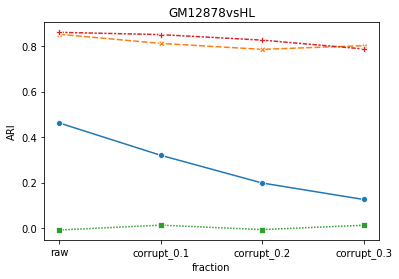

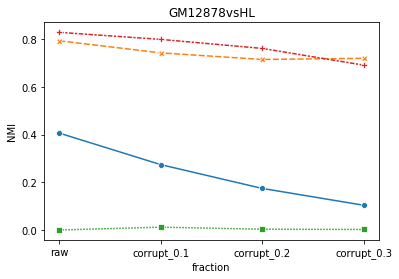

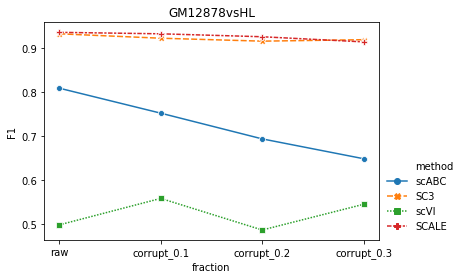

In [24]:
from scale.plot import plot_metrics

path = '../corrupt_result/'
corrupt_data_path = '../corrupt_data/'
fraction = ['raw', 'corrupt_0.1', 'corrupt_0.2', 'corrupt_0.3']

dataset = 'GM12878vsHL'
plot_metrics(path, dataset, ref, fraction = fraction)

raw
corrupt_0.1
corrupt_0.2
corrupt_0.3


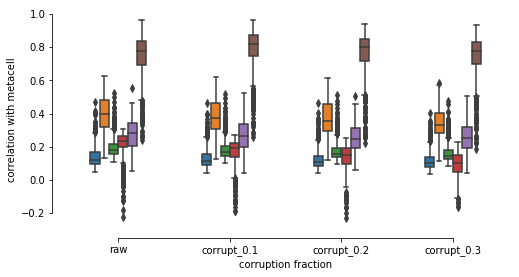

In [25]:
## 7. imputation on different corruption fraction 

import numpy as np
def get_meta(data, labels):
    meta = np.zeros(data.shape)
    for c in np.unique(labels):
        index = np.where(labels==c)[0]
        meta[:, index] = np.tile(data.iloc[:, index].mean(1), [len(index), 1]).T
    return pd.DataFrame(meta)


from scipy.stats import pearsonr

def pairwise_pearson(A, B):
    from scipy.stats import pearsonr
    corrs = []
    for i in range(A.shape[0]):
        if A.shape == B.shape:
            corr = pearsonr(A.iloc[i], B.iloc[i])[0]
        else:
            corr = pearsonr(A.iloc[i], B)[0]
        corrs.append(corr)
    return corrs

def group_boxplot(data):
    plt.figure(figsize=(8,4))
    sns.boxplot(x='corruption fraction', y='correlation with metacell', hue='method', width=0.5, data=data)
    sns.despine(offset=10, trim=True)
    plt.legend().set_visible(False)

    plt.show()
    
methods = ['Corrupted', 'scImpute', 'SAVER', 'MAGIC', 'scVI', 'SCALE']
cell_corr = []
cell_frac = []
cell_method = []

for frac in fraction:
    print(frac)
    outdir = os.path.join(path, dataset, frac)+'/'

    if frac == 'raw':
        corrupt = pd.read_csv(corrupt_data_path+'{}/data.txt'.format(dataset), sep='\t', index_col=0)
    else:
        corrupt = pd.read_csv(corrupt_data_path+'{}/data_{}.txt'.format(dataset, frac), sep='\t', index_col=0)
    scImpute = pd.read_csv(outdir+'scImpute/scimpute_count.txt', sep=' ', index_col=0)
    saver = pd.read_csv(outdir+'SAVER_imputed.txt', sep='\t', index_col=0)
    magic = pd.read_csv(outdir+'Magic_imputed.txt', sep='\t', index_col=0)
    scVI = pd.read_csv(outdir+'scVI_imputed.txt', sep='\t', index_col=0)
    scale = pd.read_csv(outdir+'imputed_data.txt', sep='\t', index_col=0)

    for data, method in zip([corrupt, scImpute, saver, magic, scVI, scale], methods):
        corr = []
        for c in np.unique(y):
            cells = np.where(y==c)[0]
            corr += pairwise_pearson(data.iloc[:, cells].T, raw.iloc[:, cells].sum(1))

        cell_corr.append(corr)
        cell_method.append([method]*raw.shape[1])
        cell_frac.append([frac]*raw.shape[1])

cell_corr = pd.Series(np.concatenate(cell_corr, axis=0))
cell_method = pd.Series(np.concatenate(cell_method, axis=0))
cell_frac = pd.Series(np.concatenate(cell_frac, axis=0))

cell_concat = pd.concat([cell_corr, cell_method, cell_frac], axis=1)
cell_concat.columns = ['correlation with metacell', 'method', 'corruption fraction']

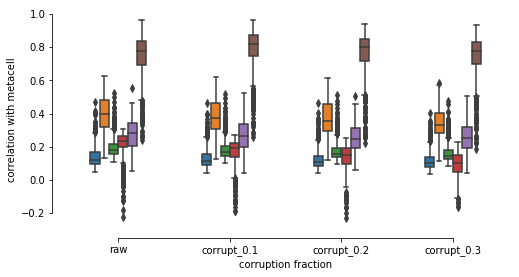

In [26]:
os.makedirs('corrupt_correlation', exist_ok=True)
cell_concat.to_csv('corrupt_correlation/metacell_correlation.txt'.format(dataset), sep='\t')
group_boxplot(cell_concat)